In [1]:
!pip install -r requirements.txt

Looking in indexes: https://build-nexus.prod.crto.in/repository/moab.pypi/simple


In [2]:
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]"

Looking in indexes: https://build-nexus.prod.crto.in/repository/moab.pypi/simple
Looking in indexes: https://build-nexus.prod.crto.in/repository/moab.pypi/simple
  Using cached jax-0.2.17-py3-none-any.whl
  Using cached https://build-nexus.prod.crto.in/repository/moab.pypi/packages/jax/0.2.16/jax-0.2.16.tar.gz (680 kB)
  Preparing metadata (setup.py) ... done
  Using cached https://build-nexus.prod.crto.in/repository/moab.pypi/packages/jax/0.2.15/jax-0.2.15.tar.gz (681 kB)
  Preparing metadata (setup.py) ... done
  Using cached https://build-nexus.prod.crto.in/repository/moab.pypi/packages/jax/0.2.14/jax-0.2.14.tar.gz (669 kB)
  Preparing metadata (setup.py) ... done
  Using cached https://build-nexus.prod.crto.in/repository/moab.pypi/packages/jax/0.2.13/jax-0.2.13.tar.gz (630 kB)
  Preparing metadata (setup.py) ... done
  Using cached https://build-nexus.prod.crto.in/repository/moab.pypi/packages/jax/0.2.12/jax-0.2.12.tar.gz (590 kB)
  Preparing metadata (setup.py) ... done


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from scipy.stats import multivariate_normal as sp_mvnorm
from scipy.stats import norm

from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
from tqdm import tqdm
import pandas as pd

import jax
import cvxpy as cvx

In [5]:
from aaai_helpers.optim import *
from aaai_helpers.eval import *
from aaai_helpers.jax_spm import *
from aaai_helpers.baselines import *
from aaai_helpers.plots import *
from aaai_helpers.utils import *

In [5]:
mu_0_v = jnp.array([[2.,1.]])
Sigma_0_v = 1*jnp.array([[3.,1.]])**2
mu_0_c = jnp.array([[1.,1.5]])
Sigma_0_c = 1*jnp.array([[2.,1.]])**2

nbucket, npol = mu_0_v.shape

rho = 0.5

mu_0, cov_0 = get_synth_data_jax(mu_0_v, mu_0_c, Sigma_0_v, Sigma_0_c, rho)    
r_v, r_c = 0., 3.

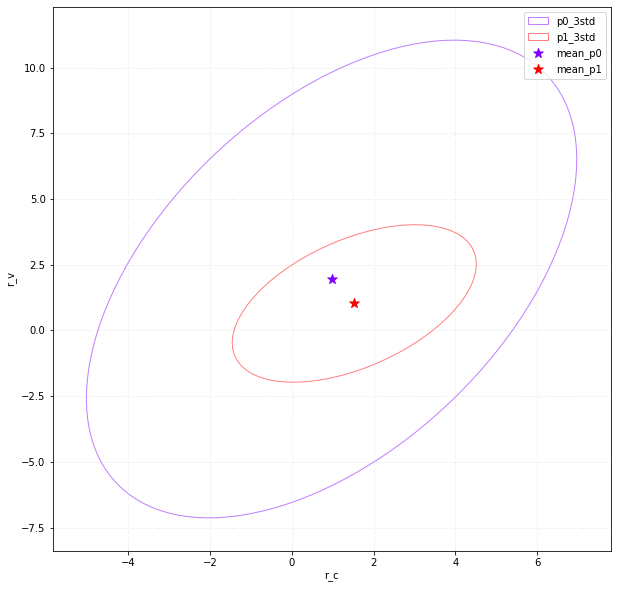

In [6]:
plot_data_2d(mu_0, cov_0, r_v, r_c, nbucket, npol)

In [7]:
### for hard bruteforce
candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
all_hard_allocs = np.array(list(itertools.product(candidates, repeat=nbucket))) ### avoid all refs as it raise singular matrix

In [8]:
### Define r_c (success region) without AB test interpretation
R_cs = np.arange(1., 7.1, 0.1)

methods = ['Bruteforce', 'LinProg', 'SuccessProbaMax']#, 'LinProg_RA']
res_2d = {i:np.zeros_like(R_cs) for i in methods}

In [9]:
for i in tqdm(range(len(R_cs))):
    hard_bf_alloc = hard_bruteforce_2d_v2(all_hard_allocs, mu_0, cov_0, 0, R_cs[i])
    res_2d['Bruteforce'][i] = evaluate_2d_v2(hard_bf_alloc, mu_0, cov_0, 0, R_cs[i])
    
    greedy_soft_alloc = greedy_2d(mu_0_v, mu_0_c, R_cs[i], nbucket, npol)
    res_2d['LinProg'][i] = evaluate_2d_v2(greedy_soft_alloc, mu_0, cov_0, 0, R_cs[i])
    
    ### initial allocation to start SPM from 
    psi_0 = np.array([[1./npol]*npol]*nbucket) ### uniform allocation
    # psi_0 = greedy_soft_alloc
    
    spm_alloc = optimize_2d_my_v2(cov_0, mu_0, 0, R_cs[i], psi_0, n_steps=10000, eta = 0.01)
    res_2d['SuccessProbaMax'][i] = evaluate_2d_v2(spm_alloc, mu_0, cov_0, 0, R_cs[i])

100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


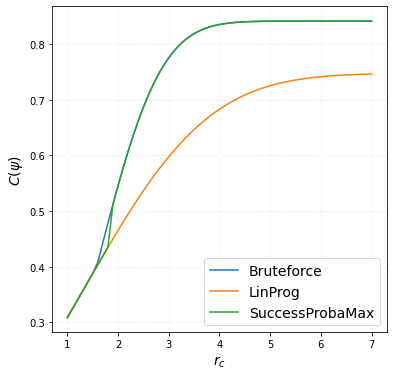

In [10]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:
    plt.plot(
        R_cs,
        res_2d[m],
        label=m
    )
    
plt.xlabel('$r_c$', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
# plt.title('Train', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [11]:
mu_0_v = jnp.array([[2.,1.]])
Sigma_0_v = 1*jnp.array([[3.,1.]])**2
mu_0_c = jnp.array([[1.,0.5]])
Sigma_0_c = 1*jnp.array([[1.,1.]])**2

nbucket, npol = mu_0_v.shape

rho = 0.5

mu_0, cov_0 = get_synth_data_jax(mu_0_v, mu_0_c, Sigma_0_v, Sigma_0_c, rho)    
r_v, r_c = 0., 1

In [13]:
### for hard bruteforce
candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
all_hard_allocs = np.array(list(itertools.product(candidates, repeat=nbucket))) ### avoid all refs as it raise singular matrix

In [14]:
### Define r_c (success region) without AB test interpretation
R_cs = np.arange(1., 7.1, 0.1)

methods = ['Bruteforce', 'LinProg', 'SuccessProbaMax']#, 'LinProg_RA']
res_2d = {i:np.zeros_like(R_cs) for i in methods}

In [15]:
for i in tqdm(range(len(R_cs))):
    hard_bf_alloc = hard_bruteforce_2d_v2(all_hard_allocs, mu_0, cov_0, 0, R_cs[i])
    res_2d['Bruteforce'][i] = evaluate_2d_v2(hard_bf_alloc, mu_0, cov_0, 0, R_cs[i])
    
    greedy_soft_alloc = greedy_2d(mu_0_v, mu_0_c, R_cs[i], nbucket, npol)
    res_2d['LinProg'][i] = evaluate_2d_v2(greedy_soft_alloc, mu_0, cov_0, 0, R_cs[i])
    
    ### initial allocation to start SPM from 
    psi_0 = np.array([[1./npol]*npol]*nbucket) ### uniform allocation
    # psi_0 = greedy_soft_alloc
    
    spm_alloc = optimize_2d_my_v2(cov_0, mu_0, 0, R_cs[i], psi_0, n_steps=10000, eta = 0.01)
    res_2d['SuccessProbaMax'][i] = evaluate_2d_v2(spm_alloc, mu_0, cov_0, 0, R_cs[i])

100%|██████████| 61/61 [00:42<00:00,  1.43it/s]


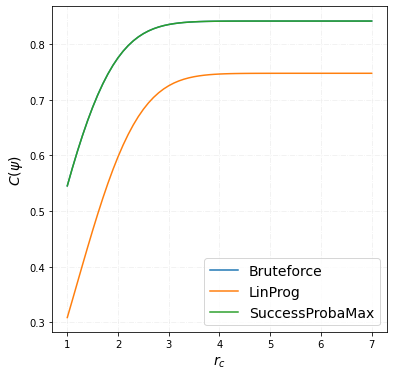

In [16]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:
    plt.plot(
        R_cs,
        res_2d[m],
        label=m
    )
    
plt.xlabel('$r_c$', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
# plt.title('Train', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [ ]:
mu_0_v = jnp.array([[2.,1.]])
Sigma_0_v = 1*jnp.array([[3.,1.]])**2
mu_0_c = jnp.array([[1.,1.5]])
Sigma_0_c = 1*jnp.array([[2.,1.]])**2

nbucket, npol = mu_0_v.shape

rho = 0.5

mu_0, cov_0 = get_synth_data_jax(mu_0_v, mu_0_c, Sigma_0_v, Sigma_0_c, rho)    
r_v, r_c = 0., 3.


np.random.seed(2480947)

N = 1000

df_sim = pd.DataFrame(
    {
        'X':np.random.choice(np.arange(nbucket), p=[1./nbucket]*nbucket, size=N),
        'pi':np.random.choice(np.arange(npol), p=[1./npol]*npol, size=N),
        'y_v':np.zeros(N),
        'y_c':np.zeros(N)
        
    }
)

for i in range(N):
    y = np.random.multivariate_normal(mu_0[df_sim.X[i]][df_sim.pi[i]], cov_0[df_sim.X[i]][df_sim.pi[i]].reshape(2,2))
    df_sim['y_v'][i] = y[0]
    df_sim['y_c'][i] = y[1]

splits_res_train = []
splits_res_test = []
n_splits = 100

for _ in tqdm(range(n_splits)):

    df_sim = df_sim.sample(frac=1)
    df_sim_train = df_sim[:int(N/2)]
    df_sim_test = df_sim[int(N/2):]

    mu_0_train = df_sim_train.groupby(['X','pi']).mean().values.reshape(nbucket,npol,2)
    cov_0_train = df_sim_train.groupby(['X','pi']).cov().values.reshape(nbucket,npol,4)

    mu_0_test = df_sim_test.groupby(['X','pi']).mean().values.reshape(nbucket,npol,2)
    cov_0_test = df_sim_test.groupby(['X','pi']).cov().values.reshape(nbucket,npol,4)

    candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
    all_hard_allocs = np.array(list(itertools.product(candidates, repeat=nbucket)))

    R_cs = np.arange(1.1, 7.1, 0.1)

    methods = ['Bruteforce', 'LinProg', 'SuccessProbaMax']#, 'LinProg_RA']
    res_2d_train = {i:np.zeros_like(R_cs) for i in methods}
    res_2d_test = {i:np.zeros_like(R_cs) for i in methods}

    for i in range(len(R_cs)):
        hard_bf_alloc = hard_bruteforce_2d_v2(all_hard_allocs, mu_0_train, cov_0_train, 0, R_cs[i])
        res_2d_train['Bruteforce'][i] = evaluate_2d_v2(hard_bf_alloc, mu_0_train, cov_0_train, 0, R_cs[i])
        res_2d_test['Bruteforce'][i] = evaluate_2d_v2(hard_bf_alloc, mu_0_test, cov_0_test, 0, R_cs[i])

        greedy_soft_alloc = greedy_2d(mu_0_train[:,:,0], mu_0_train[:,:,-1], R_cs[i], nbucket, npol)
        res_2d_train['LinProg'][i] = evaluate_2d_v2(greedy_soft_alloc, mu_0_train, cov_0_train, 0, R_cs[i])
        res_2d_test['LinProg'][i] = evaluate_2d_v2(greedy_soft_alloc, mu_0_test, cov_0_test, 0, R_cs[i])


        ### initial allocation to start SPM from 
        psi_0 = np.array([[1./npol]*npol]*nbucket) ### uniform allocation
        # psi_0 = greedy_soft_alloc

        spm_alloc = optimize_2d_my_v2(cov_0_train, mu_0_train, 0, R_cs[i], psi_0, n_steps=10000, eta = 0.01)
        res_2d_train['SuccessProbaMax'][i] = evaluate_2d_v2(spm_alloc, mu_0_train, cov_0_train, 0, R_cs[i])
        res_2d_test['SuccessProbaMax'][i] = evaluate_2d_v2(spm_alloc, mu_0_test, cov_0_test, 0, R_cs[i])
    
    splits_res_train.append(res_2d_train)
    splits_res_test.append(res_2d_test)

/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  5%|▌         | 5/100 [03:31<1:07:08, 42.41s/it]

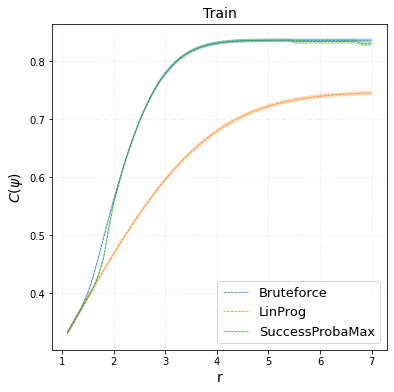

In [82]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        R_cs,
        # res_1d_train[m],
        x_tr,
        lw=0.7,
        ls='--',
        label=m#+'_train'
    )
    plt.fill_between(
        R_cs,
        (x_tr-ci_tr),
        (x_tr+ci_tr),
        alpha=0.3
    )
    
    # x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    # ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     Rs,
    #     # res_1d_train[m],
    #     x_test,
    #     label=m+'_test'
    # )
    # plt.fill_between(
    #     Rs,
    #     (x_test-ci_test),
    #     (x_test+ci_test),
    #     alpha=0.3
    # )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Train', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()

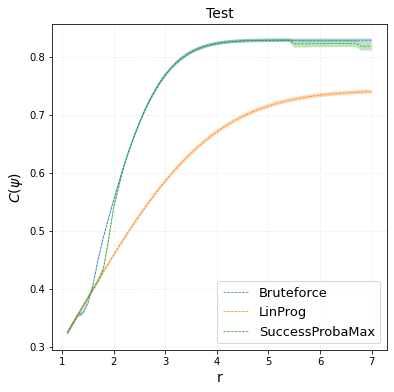

In [83]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    # x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    # ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     R_cs,
    #     # res_1d_train[m],
    #     x_tr,
    #     lw=0.7,
    #     ls='--',
    #     label=m#+'_train'
    # )
    # plt.fill_between(
    #     R_cs,
    #     (x_tr-ci_tr),
    #     (x_tr+ci_tr),
    #     alpha=0.3
    # )
    
    x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        R_cs,
        # res_1d_train[m],
        x_test,
        lw=0.7,
        ls='--',
        label=m#+'_test'
    )
    plt.fill_between(
        R_cs,
        (x_test-ci_test),
        (x_test+ci_test),
        alpha=0.3
    )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Test', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()

In [64]:
mu_0_v = jnp.array([[2.,1.]])
Sigma_0_v = 1*jnp.array([[3.,1.]])**2
mu_0_c = jnp.array([[1.,0.5]])
Sigma_0_c = 1*jnp.array([[1.,1.]])**2

nbucket, npol = mu_0_v.shape

rho = 0.5

mu_0, cov_0 = get_synth_data_jax(mu_0_v, mu_0_c, Sigma_0_v, Sigma_0_c, rho)    
r_v, r_c = 0., 1



np.random.seed(2480947)

N = 1000

df_sim = pd.DataFrame(
    {
        'X':np.random.choice(np.arange(nbucket), p=[1./nbucket]*nbucket, size=N),
        'pi':np.random.choice(np.arange(npol), p=[1./npol]*npol, size=N),
        'y_v':np.zeros(N),
        'y_c':np.zeros(N)
        
    }
)

for i in range(N):
    y = np.random.multivariate_normal(mu_0[df_sim.X[i]][df_sim.pi[i]], cov_0[df_sim.X[i]][df_sim.pi[i]].reshape(2,2))
    df_sim['y_v'][i] = y[0]
    df_sim['y_c'][i] = y[1]

splits_res_train = []
splits_res_test = []
n_splits = 100

for _ in tqdm(range(n_splits)):

    df_sim = df_sim.sample(frac=1)
    df_sim_train = df_sim[:int(N/2)]
    df_sim_test = df_sim[int(N/2):]

    mu_0_train = df_sim_train.groupby(['X','pi']).mean().values.reshape(nbucket,npol,2)
    cov_0_train = df_sim_train.groupby(['X','pi']).cov().values.reshape(nbucket,npol,4)

    mu_0_test = df_sim_test.groupby(['X','pi']).mean().values.reshape(nbucket,npol,2)
    cov_0_test = df_sim_test.groupby(['X','pi']).cov().values.reshape(nbucket,npol,4)

    candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
    all_hard_allocs = np.array(list(itertools.product(candidates, repeat=nbucket)))

    R_cs = np.arange(1., 7.1, 0.1)

    methods = ['Bruteforce', 'LinProg', 'SuccessProbaMax']#, 'LinProg_RA']
    res_2d_train = {i:np.zeros_like(R_cs) for i in methods}
    res_2d_test = {i:np.zeros_like(R_cs) for i in methods}

    for i in range(len(R_cs)):
        hard_bf_alloc = hard_bruteforce_2d_v2(all_hard_allocs, mu_0_train, cov_0_train, 0, R_cs[i])
        res_2d_train['Bruteforce'][i] = evaluate_2d_v2(hard_bf_alloc, mu_0_train, cov_0_train, 0, R_cs[i])
        res_2d_test['Bruteforce'][i] = evaluate_2d_v2(hard_bf_alloc, mu_0_test, cov_0_test, 0, R_cs[i])

        greedy_soft_alloc = greedy_2d(mu_0_train[:,:,0], mu_0_train[:,:,-1], R_cs[i], nbucket, npol)
        res_2d_train['LinProg'][i] = evaluate_2d_v2(greedy_soft_alloc, mu_0_train, cov_0_train, 0, R_cs[i])
        res_2d_test['LinProg'][i] = evaluate_2d_v2(greedy_soft_alloc, mu_0_test, cov_0_test, 0, R_cs[i])


        ### initial allocation to start SPM from 
        psi_0 = np.array([[1./npol]*npol]*nbucket) ### uniform allocation
        # psi_0 = greedy_soft_alloc

        spm_alloc = optimize_2d_my_v2(cov_0_train, mu_0_train, 0, R_cs[i], psi_0, n_steps=10000, eta = 0.01)
        res_2d_train['SuccessProbaMax'][i] = evaluate_2d_v2(spm_alloc, mu_0_train, cov_0_train, 0, R_cs[i])
        res_2d_test['SuccessProbaMax'][i] = evaluate_2d_v2(spm_alloc, mu_0_test, cov_0_test, 0, R_cs[i])
    
    splits_res_train.append(res_2d_train)
    splits_res_test.append(res_2d_test)

/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 100/100 [1:11:54<00:00, 43.14s/it]


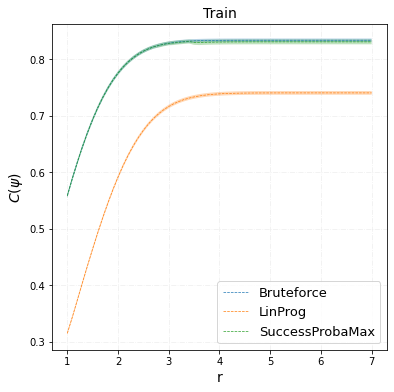

In [66]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        R_cs,
        # res_1d_train[m],
        x_tr,
        lw=0.7,
        ls='--',
        label=m#+'_train'
    )
    plt.fill_between(
        R_cs,
        (x_tr-ci_tr),
        (x_tr+ci_tr),
        alpha=0.3
    )
    
    # x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    # ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     Rs,
    #     # res_1d_train[m],
    #     x_test,
    #     label=m+'_test'
    # )
    # plt.fill_between(
    #     Rs,
    #     (x_test-ci_test),
    #     (x_test+ci_test),
    #     alpha=0.3
    # )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Train', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()

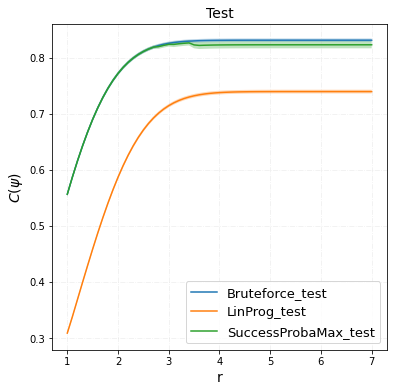

In [68]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    # x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    # ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     R_cs,
    #     # res_1d_train[m],
    #     x_tr,
    #     lw=0.7,
    #     ls='--',
    #     label=m#+'_train'
    # )
    # plt.fill_between(
    #     R_cs,
    #     (x_tr-ci_tr),
    #     (x_tr+ci_tr),
    #     alpha=0.3
    # )
    
    x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        R_cs,
        # res_1d_train[m],
        x_test,
        label=m+'_test'
    )
    plt.fill_between(
        R_cs,
        (x_test-ci_test),
        (x_test+ci_test),
        alpha=0.3
    )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Test', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()